# Denoising with the deep decoder

The code below demonstrates the denoising performance on an example image.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import glob
import heapq
import os
import random
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

from pytorch_ssim import pytorch_ssim

# Make experiments reproducible with deterministic seed.
torch.manual_seed(1)

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed(1)
    dtype = torch.cuda.FloatTensor
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


num GPUs 1


### Helper functions for displaying images

In [2]:
def myimgshow(plt, img):
    # Reshape image to channels-last, to fit matplotlib expectation.
    img = img.transpose(1, 2, 0)
    if img.shape[-1] == 1:
        # Remove channels axis for grayscale images.
        img = np.reshape(img, img.shape[:-1])
        plt.imshow(np.clip(img, 0, 1), cmap='gray')
    else:
        plt.imshow(np.clip(img, 0, 1))

def show_results(img_clean_np, img_noisy_np, img_out_np):
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 

    ax1 = fig.add_subplot(131)
    myimgshow(ax1,img_clean_np) 
    ax1.set_title('Original image')
    ax1.axis('off')

    ax2 = fig.add_subplot(132)
    myimgshow(ax2,img_noisy_np)
    img_clean_var = np_to_var(img_clean_np).type(dtype)
    img_noisy_var = np_to_var(img_noisy_np).type(dtype)
    ax2.set_title("Noisy observation, PSNR: %.2f, SSIM: %.2f" %
                  (psnr(img_clean_np, img_noisy_np), pytorch_ssim.ssim(img_clean_var, img_noisy_var)),
                 fontsize=10)
    ax2.axis('off')
    
    ax3 = fig.add_subplot(133)
    myimgshow(ax3, img_out_np)
    img_out_var = np_to_var(img_out_np).type(dtype)
    ax3.set_title("Deep-Decoder denoised image, PSNR: %.2f, SSIM: %.2f" %
                  (psnr(img_clean_np, img_out_np), pytorch_ssim.ssim(img_clean_var, img_out_var)),
                  fontsize=10) 
    ax3.axis('off')    

    plt.show()

### Benchmark

Load the list of benchmark images from the paper:
  
  ```
  Jun Xu, Hui Li, Zhetong Liang, David Zhang, and Lei Zhang
  Real-world Noisy Image Denoising: A New Benchmark
  https://arxiv.org/abs/1804.02603, 2018.
  ```

In [3]:
def benchmark_images(benchmark_dir = "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages/"):
    clean_suffix = '_mean.JPG'
    noisy_suffix = '_real.JPG'
    benchmark_clean_images = sorted(glob.glob(benchmark_dir + '*' + clean_suffix))
    benchmark_noisy_images = sorted(glob.glob(benchmark_dir + '*' + noisy_suffix))
    benchmark_pairs = []
    for clean_image_path in benchmark_clean_images:
        root_filename = clean_image_path[:-len(clean_suffix)]
        noisy_image_path = root_filename + noisy_suffix
        assert noisy_image_path in benchmark_noisy_images
        benchmark_pairs.append({"clean": clean_image_path, "noisy": noisy_image_path})
    return benchmark_pairs

In [4]:
BENCHMARK_IMAGES = benchmark_images()
print("Loaded %d benchmark pairs." % len(BENCHMARK_IMAGES))
pprint("Example: %s" % ["%d: %s" % (k,v['clean']) for k,v in enumerate(BENCHMARK_IMAGES)])

Loaded 100 benchmark pairs.
("Example: ['0: "
 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages\\\\Canon5D2_5_160_3200_chair_11_mean.JPG', "
 "'1: "
 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages\\\\Canon5D2_5_160_3200_chair_14_mean.JPG', "
 "'2: "
 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages\\\\Canon5D2_5_160_3200_chair_5_mean.JPG', "
 "'3: "
 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages\\\\Canon5D2_5_160_3200_plug_11_mean.JPG', "
 "'4: "
 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages\\\\Canon5D2_5_160_3200_plug_12_mean.JPG', "
 "'5: "
 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages\\\\Canon5D2_5_160_6400_bicycle_10_mean.JPG', "
 "'6: "
 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages\\\\Canon5D2_5_160_6400_bicycle_6_mean.JPG', "
 "'7: "
 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages

 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages\\\\NikonD800_5-6_160_6400_wall_15_mean.JPG', "
 "'64: "
 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages\\\\NikonD800_5-6_160_6400_wall_2_mean.JPG', "
 "'65: "
 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages\\\\NikonD800_5-6_160_6400_wall_6_mean.JPG', "
 "'66: "
 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages\\\\NikonD800_5-6_160_6400_wall_9_mean.JPG', "
 "'67: "
 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages\\\\NikonD800_5_100_4000_flower_12_mean.JPG', "
 "'68: "
 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages\\\\NikonD800_5_100_4000_flower_13_mean.JPG', "
 "'69: "
 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages\\\\NikonD800_5_100_4000_flower_14_mean.JPG', "
 "'70: "
 "./test_data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages\\\\NikonD800_5_100_4000_flo

## Load image

This function loads an image from the `test_data` directory, and returns:
  * numpy array of the image's pixel values.
  * a torch.Variable which refers to the numpy array.

Try "phantom256.png" or "astronaut.png".

In [5]:
def load_image(image="astronaut.png", size=None):
    if './test_data/' in image:
        img_path = image
    else:
        img_path = './test_data/' + image
    img_pil = Image.open(img_path)
    if size is not None:
        img_pil = img_pil.resize((size, size), Image.ANTIALIAS)
    img_np = pil_to_np(img_pil)
    img_clean_var = np_to_var(img_np).type(dtype)
    return img_np, img_clean_var

In [6]:
def load_benchmark_image(number=1):
    img_clean_np, img_clean_var = load_image(BENCHMARK_IMAGES[number]['clean'], size=512)
    img_noisy_np, img_noisy_var = load_image(BENCHMARK_IMAGES[number]['noisy'], size=512)
    output_depth = img_clean_np.shape[0]
    return img_clean_np, img_clean_var, img_noisy_np, img_noisy_var, output_depth

Image shape: (3, 1024, 1024)
Image shape: (1, 12, 12)


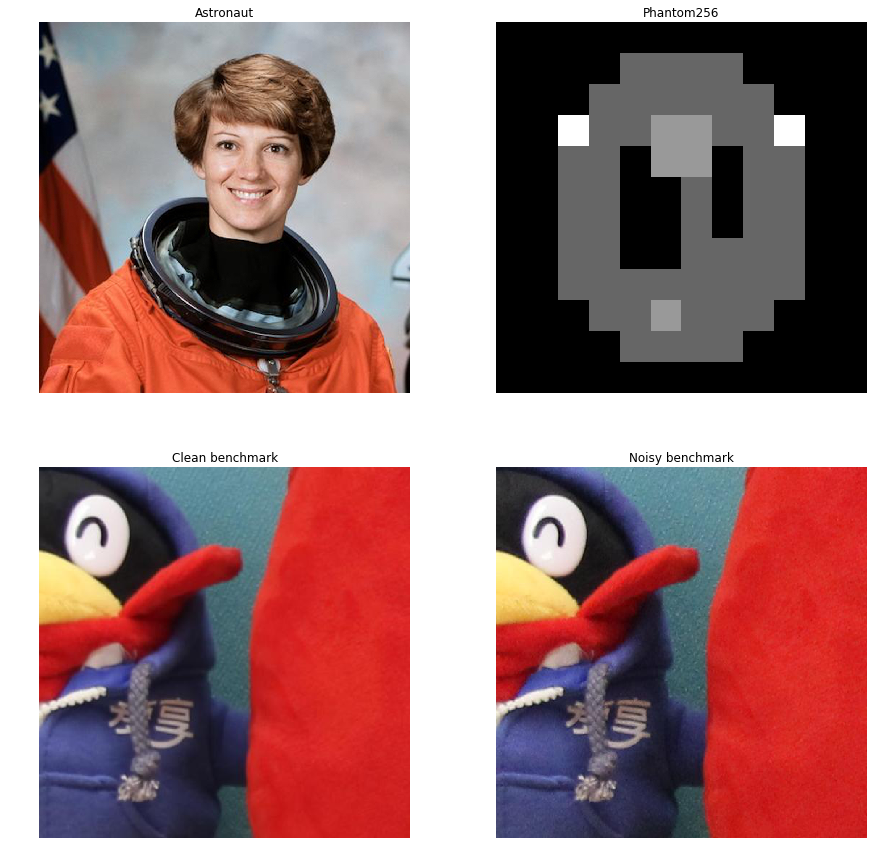

In [7]:
img_np, img_var = load_image("astronaut.png", size=1024)
print("Image shape: %s" % str(img_np.shape))

fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 

ax1 = fig.add_subplot(221)
myimgshow(ax1, img_np)
ax1.set_title('Astronaut')
ax1.axis('off')

img_np, img_var = load_image("phantom256.png", size=12)
print("Image shape: %s" % str(img_np.shape))

ax1 = fig.add_subplot(222)
myimgshow(ax1, img_np)
ax1.set_title('Phantom256')
ax1.axis('off')

clean_img_np, clean_image_var, noisy_img_np, noisy_image_var, _ = load_benchmark_image(36)
ax1 = fig.add_subplot(223)
myimgshow(ax1, clean_img_np)
ax1.set_title('Clean benchmark')
ax1.axis('off')
ax1 = fig.add_subplot(224)
myimgshow(ax1, noisy_img_np)
ax1.set_title('Noisy benchmark')
ax1.axis('off')

plt.show()

### Expected output
```
Image shape: (3, 1024, 1024)
Image shape: (1, 12, 12)
```
Then four images: an astronaut, a weird gray blob, a less-noisy image of a penguin toy, and a noisier image of the same penguin toy.

## Generate noisy image

Takes in a numpy array image and adds noise.

Returns:
 * A numpy array of the noisy image.
 * A torch.Variable of the noisy image.
 * The output depth (as an int) of the image. For RGB images this is 3, for grayscale it's 1.

In [8]:
def generate_noisy_image(orig_img_np, sigma=30, independent_channels=False):
    # Because our image is normalized, sigma must be scaled.
    sigma /= 255

    if independent_channels:
        # Create independent noise in each channel
        noise = np.random.normal(scale=sigma, size=orig_img_np.shape)
    else:
        # Create identical noise in each channel
        noise = np.random.normal(scale=sigma, size=orig_img_np.shape[1:])
        noise = np.array( [noise]*orig_img_np.shape[0] )

    # Add noise to image.
    img_noisy_np = np.clip(orig_img_np + noise , 0, 1).astype(np.float32)
    img_noisy_var = np_to_var(img_noisy_np).type(dtype)

    output_depth = orig_img_np.shape[0] 
    print("Image size: ", orig_img_np.shape)
    
    return img_noisy_np, img_noisy_var, output_depth

Image size:  (3, 512, 512)
Image shape: (3, 512, 512)
Image size:  (1, 256, 256)
Image shape: (1, 256, 256)


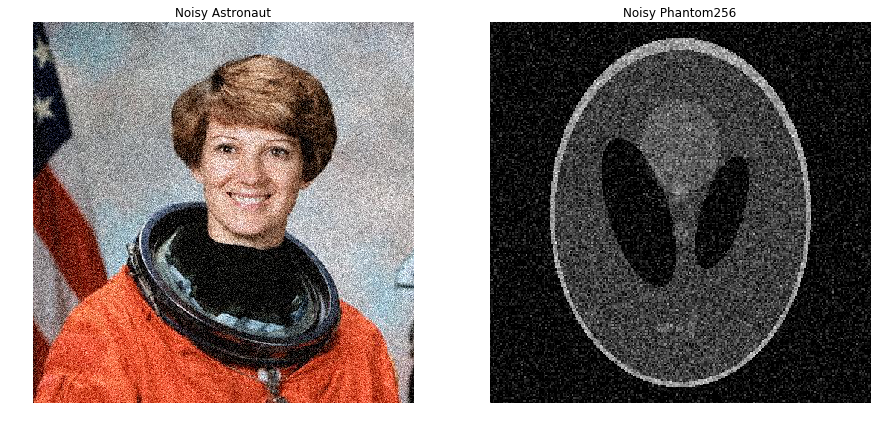

In [9]:
img_np, img_var = load_image("astronaut.png")
img_noisy_np, img_noisy_var, output_depth = generate_noisy_image(img_np, sigma=30)
print("Image shape: %s" % str(img_np.shape))

fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 

ax1 = fig.add_subplot(121)
myimgshow(ax1, img_noisy_np)
ax1.set_title('Noisy Astronaut')
ax1.axis('off')

img_np, img_var = load_image("phantom256.png", size=256)
img_noisy_np, img_noisy_var, output_depth = generate_noisy_image(img_np, sigma=1)
print("Image shape: %s" % str(img_noisy_np.shape))

ax1 = fig.add_subplot(122)
myimgshow(ax1, img_noisy_np)
ax1.set_title('Noisy Phantom256')
ax1.axis('off')

plt.show()

## Denoise noisy image

In [10]:
def denoise_image(img_noisy_var,
                  img_clean_var,
                  output_depth,
                  iterations=1000,
                  
                  alpha=0.01,
                  regularization_noise=0.015,
                  opt_input=False,
                  reg_noise_std=0.015,
                  reg_noise_decayevery=100000,
                  mask_var=None,
                  apply_f=None,
                  loss_func=None,
                  mse_loss_weight=None,
                  decaylr=False,
                  net_input=None,
                  net_input_gen="downsample",
                  find_best=False,
                  
                  num_channels_up=[128]*5, 
                  filter_size_up=1,
                  need_sigmoid=True, 
                  pad='reflection', 
                  upsample_mode='bilinear', 
                  act_fun=nn.ReLU(),
                  kernel_size=1,
                  bn_before_act = False,
                  bn_affine = True,
                  ):

    net = decodernw(
        num_output_channels = output_depth, 
        num_channels_up = num_channels_up, 
        filter_size_up = filter_size_up,
        need_sigmoid = need_sigmoid, 
        pad = pad, 
        upsample_mode = upsample_mode, 
        act_fun = act_fun,
        kernel_size = kernel_size,
        bn_before_act = bn_before_act,
        bn_affine = bn_affine).type(dtype)
    
    mse_n, mse_t, ni, net = fit(
        net = net,
        img_noisy_var = img_noisy_var,
        num_channels = num_channels_up,
        img_clean_var = img_clean_var,
        num_iter = iterations,
        LR = alpha,
        OPTIMIZER = 'adam',
        opt_input = opt_input,
        reg_noise_std = reg_noise_std,
        reg_noise_decayevery = reg_noise_decayevery,
        mask_var = mask_var,
        apply_f = apply_f,
        loss_func = loss_func,
        mse_loss_weight = mse_loss_weight,
        decaylr = decaylr,
        net_input = net_input,
        net_input_gen = net_input_gen,
        find_best=find_best)
    
    # Get the output from the network.
    img_out_np = net(ni.type(dtype)).data.cpu().numpy()[0]
    
    # Random input.
    # new_input = Variable(torch.zeros(ni.shape))
    # new_input.data.uniform_()
    # img_out_np = net(new_input.type(dtype)).data.cpu().numpy()[0]
    
    return img_out_np

## Hyperparameter search
This function searches through a range of hyperparameters randomly.

In [11]:
# image = "astronaut.png"
# img_clean_np, img_clean_var = load_image(image, size=256)
# img_noisy_np, img_noisy_var, output_depth = generate_noisy_image(img_clean_np, sigma=30)

img_clean_np, img_clean_var = load_image(BENCHMARK_IMAGES[75]['clean'], size=512)
img_noisy_np, img_noisy_var = load_image(BENCHMARK_IMAGES[75]['noisy'], size=512)
output_depth = img_clean_np.shape[0]

def hyperparameter_search(params, search_iterations=100, num_winners=10, display=True):
    max_ssim = 0.0
    max_psnr = 0.0
    ssim_params_pq = []
    psnr_params_pq = []
    for i in range(search_iterations):
        print("== Hunting for best PSNR scores. Iteration %d" % i)
        iter_params = {}
        for param, type_range in params.items():
            t, r = type_range
            if t == "choice":
                iter_params[param] = random.choice(r)
            elif t == "uniform":
                iter_params[param] = random.uniform(r[0], r[1])
            elif t == "pow10":
                iter_params[param] = 10.0 ** random.uniform(r[0], r[1])
            elif t == "listmult":
                iter_params[param] = list([random.choice(r[0])] * random.choice(r[1]))
            elif t == "randint":
                iter_params[param] = random.randint(r[0], r[1])
            else:
                iter_params[param] = r
        img_out_np = denoise_image(img_noisy_var, img_clean_var, output_depth, **iter_params)
        img_out_var = np_to_var(img_out_np).type(dtype)
        snr, ssim = psnr(img_clean_np, img_out_np), pytorch_ssim.ssim(img_clean_var, img_out_var)
        print("PSNR: %.2f, SSIM: %.2f" % (snr, ssim))
        heapq.heappush(ssim_params_pq, (ssim, iter_params))
        heapq.heappush(psnr_params_pq, (snr, iter_params))
        new_max = False
        if snr > max_psnr:
            max_psnr = snr
            new_max = True
            print("New max PSNR!")
        if ssim > max_ssim:
            max_ssim = ssim
            new_max = True
            print("New max SSIM!")
        if display or new_max:
            pprint(iter_params)
        if new_max:
            show_results(img_clean_np, img_noisy_np, img_out_np)
            
    psnr_winners = heapq.nlargest(num_winners, psnr_params_pq)
    ssim_winners = heapq.nlargest(num_winners, ssim_params_pq)
    return list(psnr_winners+ssim_winners)[:num_winners]

== Hunting for best PSNR scores. Iteration 0
network input shape:  [1, 16, 8, 8]
downsampled image shape:  torch.Size([1, 16, 8, 8])
optimize with adam 0.01
PSNR: 17.52, SSIM: 0.74 loss 0.066786  Actual loss 0.065959 Actual loss orig 0.065847 MSE Loss 0.065847 Noise Energy 0.000322 
New max PSNR!
New max SSIM!
{'act_fun': ELU(alpha=1.0),
 'iterations': 10,
 'kernel_size': 3,
 'net_input_gen': 'downsample',
 'num_channels_up': [16, 16, 16, 16, 16, 16],
 'reg_noise_std': 0.0025223212040869263}


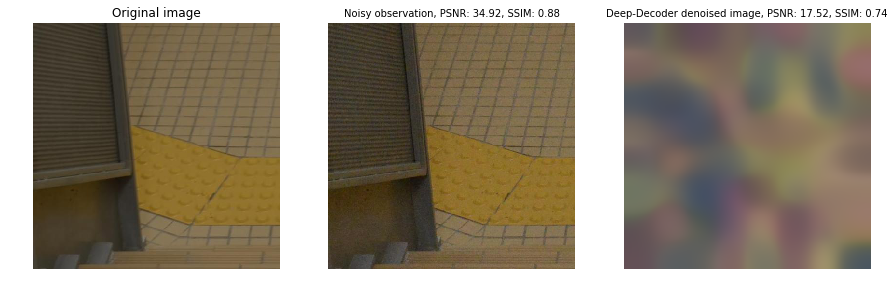

== Hunting for best PSNR scores. Iteration 1
network input shape:  [1, 128, 8, 8]
downsampled image shape:  torch.Size([1, 128, 8, 8])
optimize with adam 0.01
PSNR: 21.66, SSIM: 0.79 loss 0.055627  Actual loss 0.054757 Actual loss orig 0.054522 MSE Loss 0.054522 Noise Energy 0.000322 
New max PSNR!
New max SSIM!
{'act_fun': LeakyReLU(negative_slope=0.1, inplace),
 'iterations': 10,
 'kernel_size': 1,
 'net_input_gen': 'downsample',
 'num_channels_up': [128, 128, 128, 128, 128, 128],
 'reg_noise_std': 0.0035736925013625516}


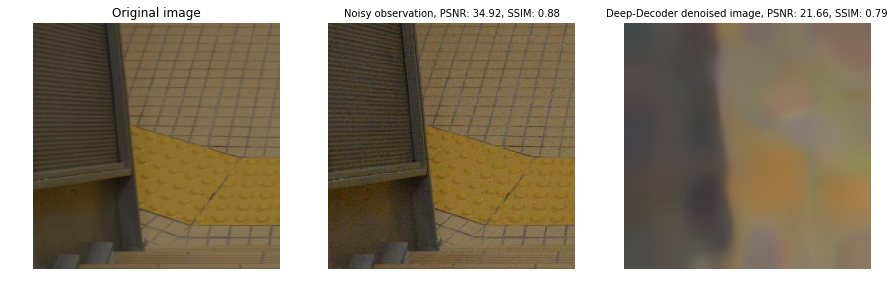

== Hunting for best PSNR scores. Iteration 2
network input shape:  [1, 128, 4, 4]
downsampled image shape:  torch.Size([1, 128, 4, 4])
optimize with adam 0.01
PSNR: 19.21, SSIM: 0.77 loss 0.055127  Actual loss 0.054316 Actual loss orig 0.054366 MSE Loss 0.054366 Noise Energy 0.000322 
{'act_fun': Sigmoid(),
 'iterations': 10,
 'kernel_size': 1,
 'net_input_gen': 'downsample',
 'num_channels_up': [128, 128, 128, 128, 128, 128, 128],
 'reg_noise_std': 0.001994723367701303}


[(21.661111842534513,
  {'iterations': 10,
   'reg_noise_std': 0.0035736925013625516,
   'num_channels_up': [128, 128, 128, 128, 128, 128],
   'net_input_gen': 'downsample',
   'act_fun': LeakyReLU(negative_slope=0.1, inplace),
   'kernel_size': 1})]

In [12]:
hyperparameter_ranges = {
    'iterations': (None, 10),
    'reg_noise_std': ('pow10', (-5.0, -1.0)),
    'num_channels_up': ('listmult', ([16,32,64,128],[2,3,4,5,6,7])),
    'net_input_gen': ('choice', ["random","downsample"]),
    'act_fun': ('choice', [nn.SELU(), nn.ELU(), nn.ReLU6(), nn.Sigmoid(), nn.LeakyReLU(0.1, inplace=True)]),
    'kernel_size': ('choice', [1, 3])
}
hyperparameter_search(hyperparameter_ranges, search_iterations=3, num_winners=1, display=True)

In [15]:
def benchmark_with_best_hyperparameters(
    large_train_iterations=10000, small_train_iterations=100, hyperparameter_search_iterations=100, best_hyperparameters=None):
    hyperparameter_ranges = {
        'iterations': (None, small_train_iterations),
        'reg_noise_std': ('pow10', (-10.0, -1.0)),
        'num_channels_up': ('listmult', ([128,196],[3,4,5,6,7])),
        'net_input_gen': ('choice', ["random","downsample"]),
        'act_fun': ('choice', [nn.ReLU(), nn.ReLU6(), nn.Sigmoid(), nn.LeakyReLU(0.1, inplace=True), nn.LeakyReLU(0.2, inplace=True)]),
        'kernel_size': ('choice', [1, 3, 5])
    }
    if best_hyperparameters is None:
        best_hyperparameters = hyperparameter_search(hyperparameter_ranges,
                                                     search_iterations=hyperparameter_search_iterations,
                                                     num_winners=3,
                                                     display=True)
    print("=========")
    print("Found winning hyperparameter configurations for both PSNR and SSIM scores.")
    print("Will reuse these hyperparameters for longer training cycles.")
    pprint(best_hyperparameters)
    print("=========")
    seen_scores = set()
    for score, hp in best_hyperparameters:
        if score in seen_scores:
            continue
        seen_scores.add(score)
        hp['iterations'] = large_train_iterations
        print("===== Switching to hyperparameters:")
        pprint(hp)
        
        for benchmark_number in range(len(BENCHMARK_IMAGES)):
            print("Benchmarking on image %d: %s" % (benchmark_number, BENCHMARK_IMAGES[benchmark_number]['clean']))
            img_clean_np, img_clean_var, img_noisy_np, img_noisy_var, output_depth = load_benchmark_image(benchmark_number)
            
            # Denoise the noisy image.
            img_out_np = denoise_image(img_noisy_var, img_clean_var, output_depth, **hp)
            img_out_var = np_to_var(img_out_np).type(dtype)
            
            # Compute final PSNR and SSIM scores.
            snr, ssim = psnr(img_clean_np, img_out_np), pytorch_ssim.ssim(img_clean_var, img_out_var)
            print("PSNR: %.2f, SSIM: %.2f" % (snr, ssim))
            show_results(img_clean_np, img_noisy_np, img_out_np)
    return best_hyperparameters

== Hunting for best PSNR scores. Iteration 0
network input shape:  [1, 196, 64, 64]
optimize with adam 0.01
PSNR: 32.80, SSIM: 0.84 loss 0.001060  Actual loss 0.000875 Actual loss orig 0.000562 MSE Loss 0.000562 Noise Energy 0.000322          
New max PSNR!
New max SSIM!
{'act_fun': ReLU(),
 'iterations': 100,
 'kernel_size': 1,
 'net_input_gen': 'random',
 'num_channels_up': [196, 196, 196],
 'reg_noise_std': 0.01520959478091197}


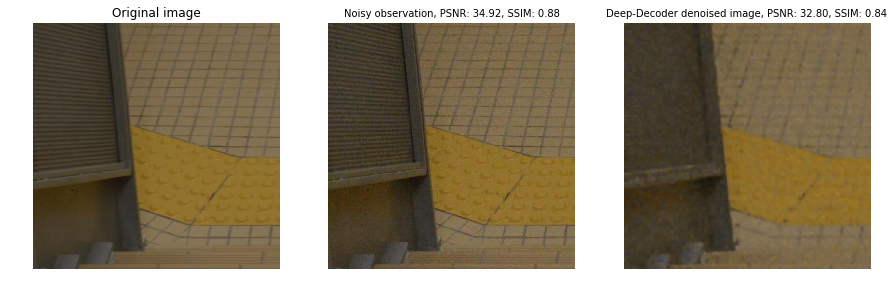

== Hunting for best PSNR scores. Iteration 1
network input shape:  [1, 196, 16, 16]
downsampled image shape:  torch.Size([1, 196, 16, 16])
optimize with adam 0.01
PSNR: 9.50, SSIM: 0.05n loss 0.112737  Actual loss 0.112707 Actual loss orig 0.112707 MSE Loss 0.112707 Noise Energy 0.000322          
{'act_fun': Sigmoid(),
 'iterations': 100,
 'kernel_size': 5,
 'net_input_gen': 'downsample',
 'num_channels_up': [196, 196, 196, 196, 196],
 'reg_noise_std': 7.665879335251053e-09}
== Hunting for best PSNR scores. Iteration 2
network input shape:  [1, 128, 64, 64]
downsampled image shape:  torch.Size([1, 128, 64, 64])
optimize with adam 0.01
PSNR: 22.92, SSIM: 0.62 loss 0.006460  Actual loss 0.006209 Actual loss orig 0.006031 MSE Loss 0.006031 Noise Energy 0.000322          
{'act_fun': Sigmoid(),
 'iterations': 100,
 'kernel_size': 1,
 'net_input_gen': 'downsample',
 'num_channels_up': [128, 128, 128],
 'reg_noise_std': 0.005302917651466976}
== Hunting for best PSNR scores. Iteration 3
netw

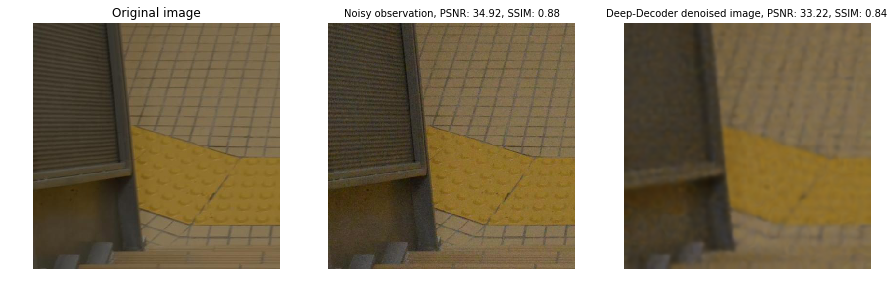

== Hunting for best PSNR scores. Iteration 5
network input shape:  [1, 196, 16, 16]
downsampled image shape:  torch.Size([1, 196, 16, 16])
optimize with adam 0.01
PSNR: 32.70, SSIM: 0.83 loss 0.000794  Actual loss 0.000552 Actual loss orig 0.000552 MSE Loss 0.000552 Noise Energy 0.000322          
{'act_fun': ReLU(),
 'iterations': 100,
 'kernel_size': 1,
 'net_input_gen': 'downsample',
 'num_channels_up': [196, 196, 196, 196, 196],
 'reg_noise_std': 1.1121574583144143e-10}
== Hunting for best PSNR scores. Iteration 6
network input shape:  [1, 128, 4, 4]
optimize with adam 0.01
PSNR: 31.62, SSIM: 0.83 loss 0.001023  Actual loss 0.000754 Actual loss orig 0.000754 MSE Loss 0.000754 Noise Energy 0.000322          
{'act_fun': LeakyReLU(negative_slope=0.1, inplace),
 'iterations': 100,
 'kernel_size': 1,
 'net_input_gen': 'random',
 'num_channels_up': [128, 128, 128, 128, 128, 128, 128],
 'reg_noise_std': 8.790391550652729e-07}
== Hunting for best PSNR scores. Iteration 7
network input sha

In [ ]:
BEST_HYPERPARAMETERS = benchmark_with_best_hyperparameters(large_train_iterations=10000, small_train_iterations=100, hyperparameter_search_iterations=100, best_hyperparameters = BEST_HYPERPARAMETERS)
%notebook -e benchmark_output.ipynb

In [ ]:
BEST_HYPERPARAMETERS